In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
from statsmodels.graphics.mosaicplot import mosaic
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

<h2> Data preparation </h2>

In [2]:
#importing dataset
df = pd.read_csv('oasis_longitudinal.csv')

In [3]:
df['Group'].value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

In [4]:
df.tail()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323
372,OAS2_0186,OAS2_0186_MR3,Nondemented,3,1608,F,R,65,13,2.0,30.0,0.0,1333,0.801,1.317


In [5]:
#Removing redundant data
df = df.drop(['Hand', 'MR Delay', 'Visit', 'Subject ID', 'MRI ID'], axis = 1)
df.tail()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
368,Demented,M,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,Demented,M,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,Nondemented,F,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,Nondemented,F,63,13,2.0,30.0,0.0,1327,0.796,1.323
372,Nondemented,F,65,13,2.0,30.0,0.0,1333,0.801,1.317


In [6]:
df.describe()

,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [7]:
#checking for null values
df.isna().sum()

Group     0
M/F       0
Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

In [8]:
#dropping null values from MMSE
df = df.dropna(subset=['MMSE'])

<AxesSubplot:xlabel='SES', ylabel='Density'>

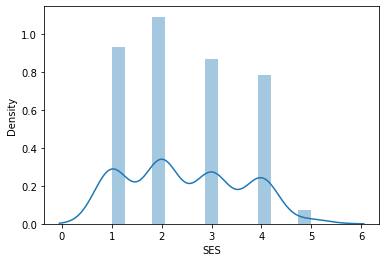

In [9]:
sns.distplot(df['SES'], hist = True)

<AxesSubplot:xlabel='SES', ylabel='Density'>

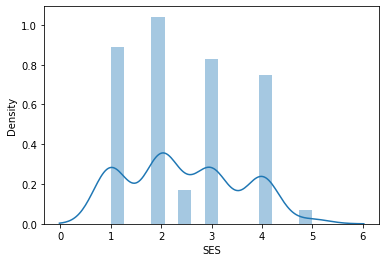

In [10]:
sns.distplot(df["SES"].fillna(df["SES"].mean()), hist=True)

<AxesSubplot:xlabel='SES', ylabel='Density'>

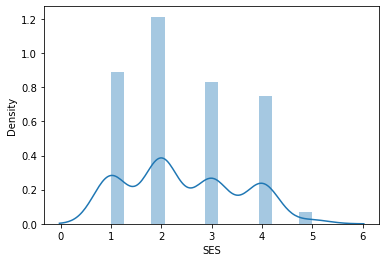

In [11]:
sns.distplot(df["SES"].fillna(df["SES"].median()), hist=True)

In [12]:
#replacing null values with mean so as to avoid change in distribution
df["SES"].fillna(df["SES"].mean(), inplace=True)

In [13]:
#confirming no more null values
df.isna().sum()

Group    0
M/F      0
Age      0
EDUC     0
SES      0
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

In [14]:
#Replacing 'Converted' group as 'Demented'
df['Group'] = df['Group'].replace('Converted', 'Demented')

In [15]:
#converting categorical to numeric data
df['M/F'] = df['M/F'].replace('M', '0')
df['M/F'] = df['M/F'].replace('F', '1')

df['GroupNum'] = df['Group']
df['GroupNum'] = df['GroupNum'].replace('Nondemented', '0')
df['GroupNum'] = df['GroupNum'].replace('Demented', '1')

In [16]:
#converting data type from object to int
df['GroupNum'] = pd.to_numeric(df['GroupNum'])
df['M/F'] = pd.to_numeric(df['M/F'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 0 to 372
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Group     371 non-null    object 
 1   M/F       371 non-null    int64  
 2   Age       371 non-null    int64  
 3   EDUC      371 non-null    int64  
 4   SES       371 non-null    float64
 5   MMSE      371 non-null    float64
 6   CDR       371 non-null    float64
 7   eTIV      371 non-null    int64  
 8   nWBV      371 non-null    float64
 9   ASF       371 non-null    float64
 10  GroupNum  371 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 34.8+ KB


In [18]:
df.tail()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,GroupNum
368,Demented,0,82,16,1.0,28.0,0.5,1693,0.694,1.037,1
369,Demented,0,86,16,1.0,26.0,0.5,1688,0.675,1.040,1
370,Nondemented,1,61,13,2.0,30.0,0.0,1319,0.801,1.331,0
371,Nondemented,1,63,13,2.0,30.0,0.0,1327,0.796,1.323,0
372,Nondemented,1,65,13,2.0,30.0,0.0,1333,0.801,1.317,0


<h2> Data exploration </h2>

<AxesSubplot:xlabel='Age', ylabel='Density'>

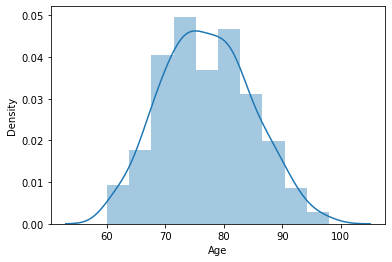

In [19]:
#distribution of age
sns.distplot(df['Age'], bins = 10, hist = True)

<AxesSubplot:xlabel='EDUC', ylabel='Density'>

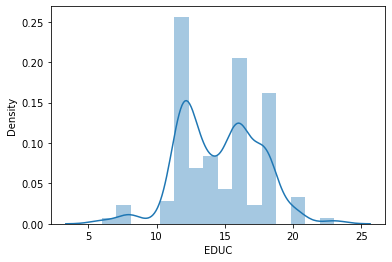

In [20]:
#distribution of educaiton
sns.distplot(df['EDUC'], hist = True)

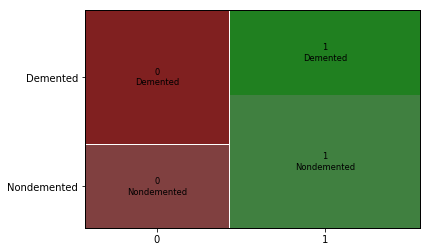

In [21]:
#distribution by gender
mos = mosaic(df, ['M/F', 'Group'])

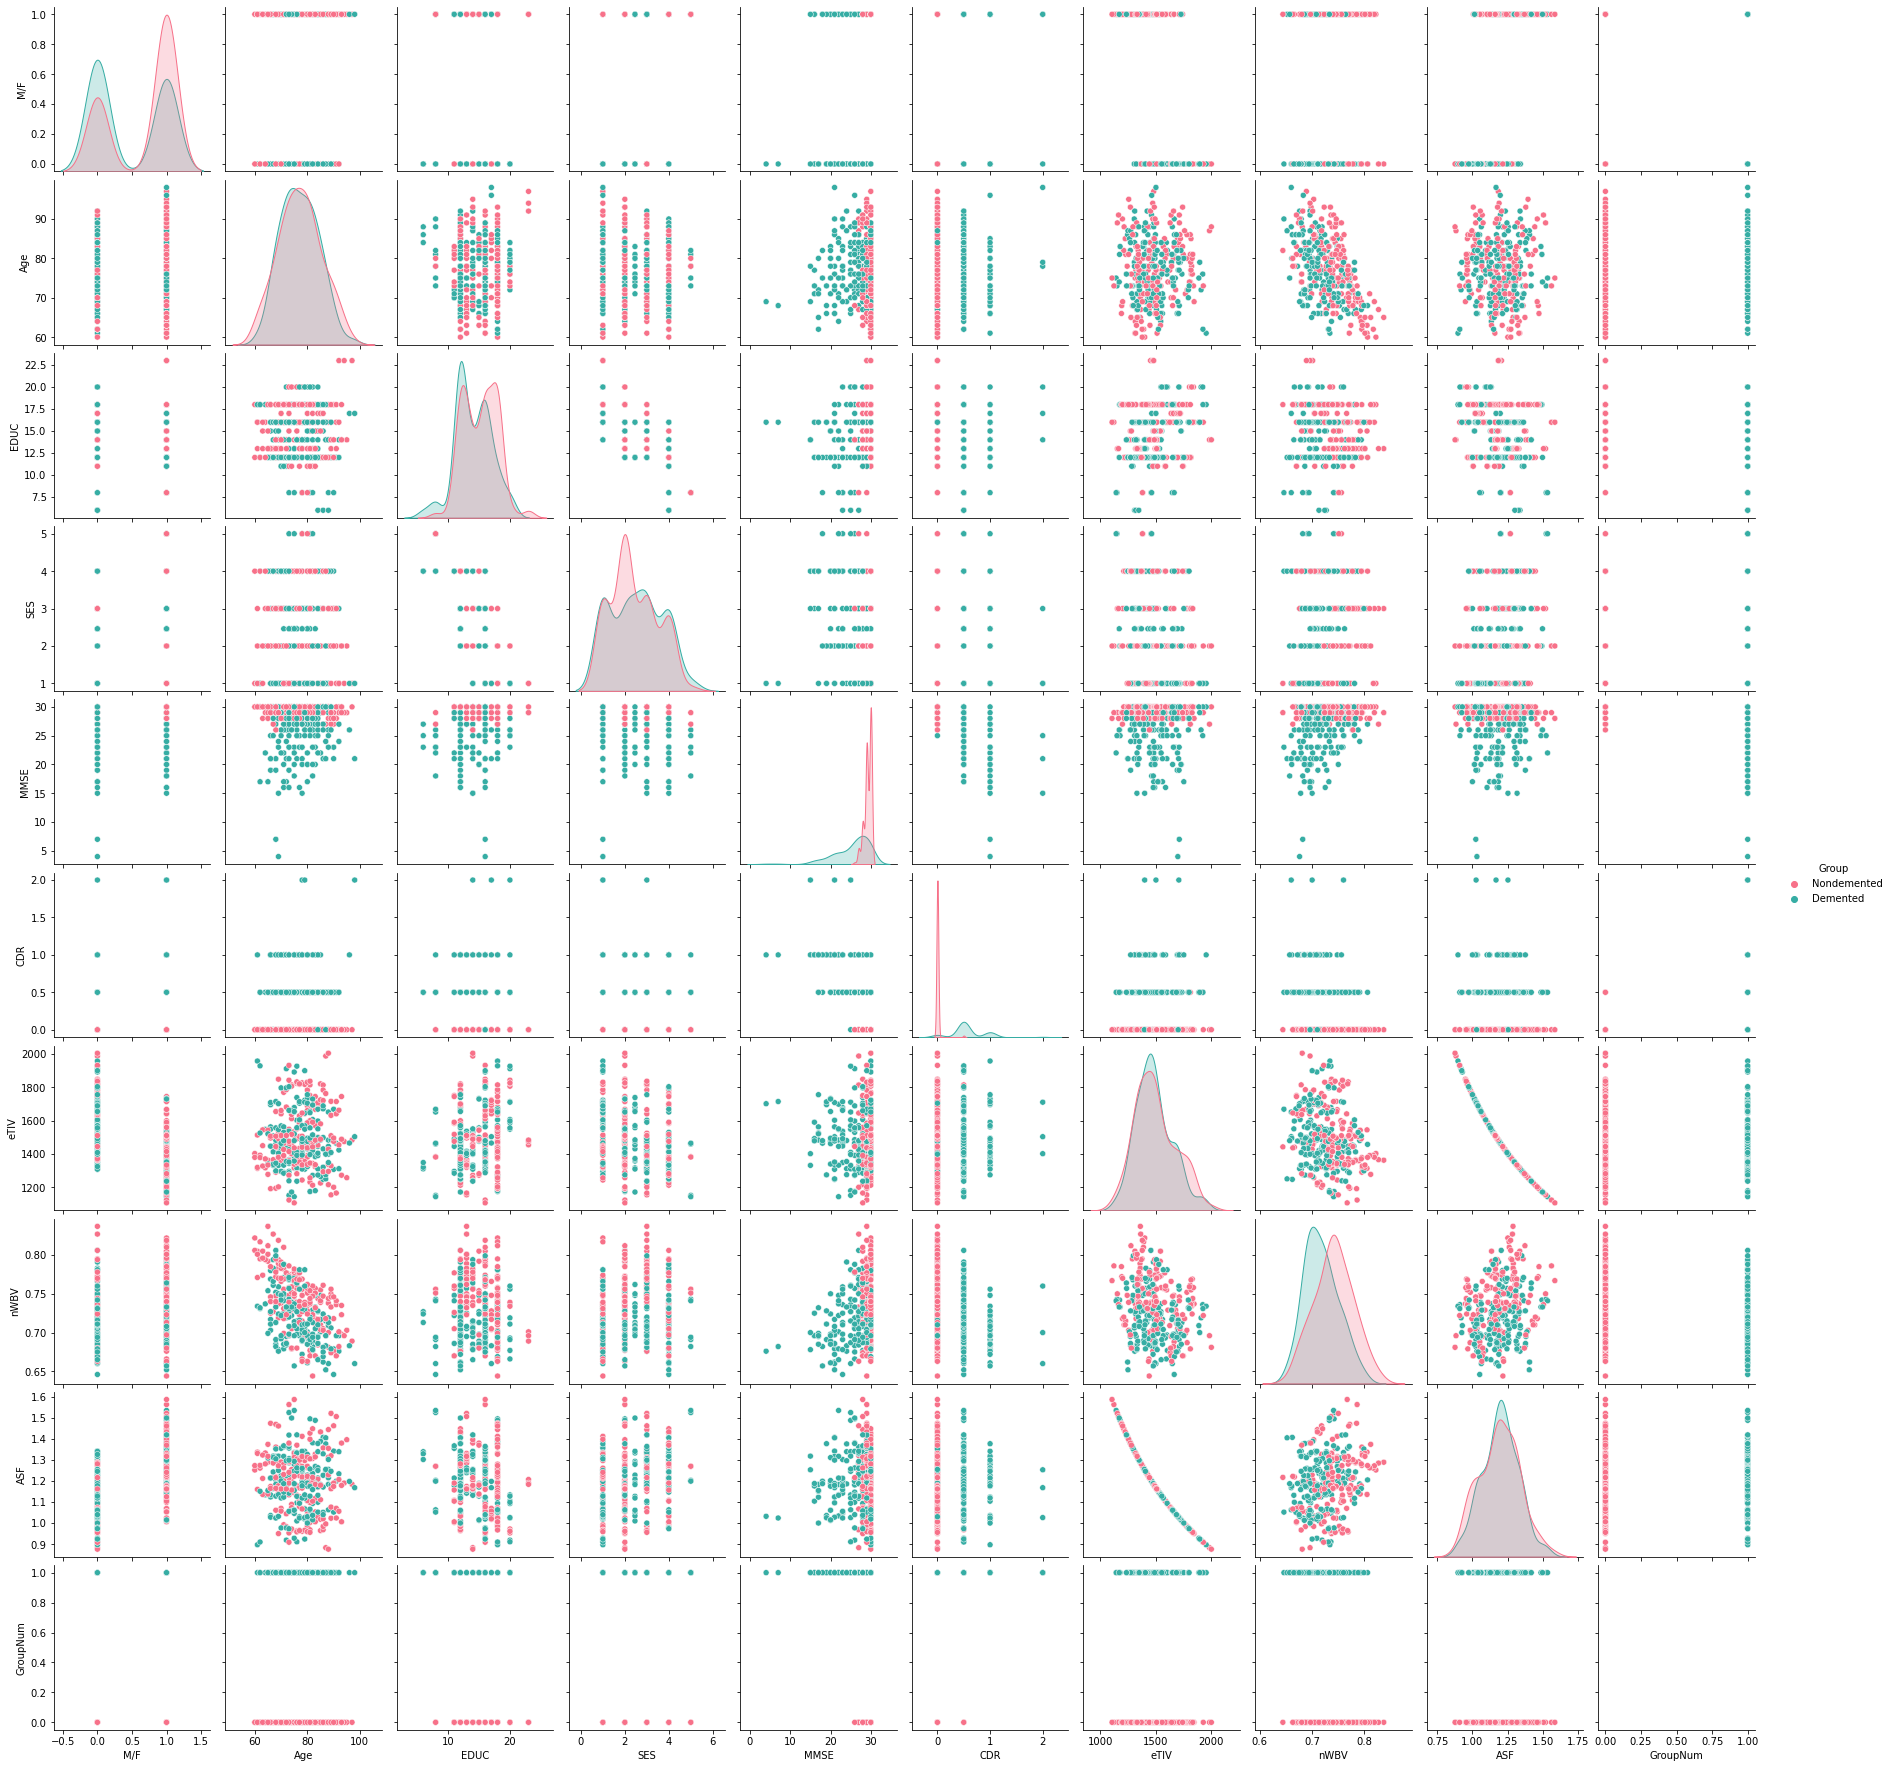

In [22]:
sns.pairplot(df, hue = 'Group', palette='husl')

<h2> Feature selection </h2>

In [23]:
corr = df.corr()
corr.style.background_gradient(cmap='PRGn')

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,GroupNum
M/F,1.000000,0.038428,-0.085415,0.044615,0.166860,-0.213504,-0.570330,0.249164,0.559989,-0.228007
Age,0.038428,1.000000,-0.028599,-0.046669,0.055612,-0.025147,0.041434,-0.518254,-0.033957,-0.005226
EDUC,-0.085415,-0.028599,1.000000,-0.710247,0.194884,-0.145614,0.250887,-0.011183,-0.234484,-0.189038
SES,0.044615,-0.046669,-0.710247,1.000000,-0.146913,0.074115,-0.256631,0.089450,0.250162,0.060868
MMSE,0.166860,0.055612,0.194884,-0.146913,1.000000,-0.686519,-0.032084,0.341912,0.040052,-0.524775
CDR,-0.213504,-0.025147,-0.145614,0.074115,-0.686519,1.000000,0.042450,-0.350473,-0.053767,0.777360
eTIV,-0.570330,0.041434,0.250887,-0.256631,-0.032084,0.042450,1.000000,-0.209981,-0.989123,-0.032973
nWBV,0.249164,-0.518254,-0.011183,0.089450,0.341912,-0.350473,-0.209981,1.000000,0.213914,-0.313450
ASF,0.559989,-0.033957,-0.234484,0.250162,0.040052,-0.053767,-0.989123,0.213914,1.000000,0.020387
GroupNum,-0.228007,-0.005226,-0.189038,0.060868,-0.524775,0.777360,-0.032973,-0.313450,0.020387,1.000000


In [24]:
pd.DataFrame(abs(corr['GroupNum']).sort_values(ascending=False)).rename(columns={'GroupNum' : 'Correlation with target'})

,Correlation with target
GroupNum,1.000000
CDR,0.777360
MMSE,0.524775
nWBV,0.313450
M/F,0.228007
EDUC,0.189038
SES,0.060868
eTIV,0.032973
ASF,0.020387
Age,0.005226


<h3> Features- highest to lowest correlation with group</h3>
<ul><li>CDR</li>
    <li>MMSE</li>
    <li>nWBV</li>
    <li>M/F</li>
    <li>EDUC</li>
    <li>SES</li>
    <li>eTIV</li>
    <li>ASF</li>
    <li>Age</li>

<h2> Model building </h2>

In [25]:
#models under consideration

models = ['Logistic Regression',
           'Random Forest',
           'Support Vector Machine',
           'KNeighbors',
           'Decision Tree',
           'XGBoost']

In [26]:
def compareModels(X_train, X_test, y_train, y_test):
    #building models
    LR = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=555)
    RF = RandomForestClassifier(n_estimators = 100, random_state=555)
    SVM = SVC(random_state=0, probability=True)
    KNC = KNeighborsClassifier()
    DTC = DecisionTreeClassifier()
    clf_XGB = XGBClassifier(n_estimators = 100, seed=555, use_label_encoder=False, eval_metric='logloss')

    trainAccuracies = []
    testAccuracies = []
    print('5-fold cross validation:\n')
    for clf, label in zip([LR, RF, SVM, KNC, DTC, clf_XGB],
                          models):
        #fitting the model
        md = clf.fit(X_train, y_train)
        
        #cross-validation scores (accuracies)
        scores = sklearn.model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")
        print("Train CV Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))
        trainAccuracies.append(scores.mean())
        testAcc = sklearn.metrics.accuracy_score(clf.predict(X_test), y_test)
        testAccuracies.append(testAcc)
        print("Test Accuracy: %0.4f " % (testAcc))
        
    return trainAccuracies, testAccuracies

In [27]:
#model with all features from data set

X = df.drop(columns=['GroupNum', 'Group'])
y = df['GroupNum']
print('For all features')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=50)
trainAccurAll, testAccurAll = compareModels(X_train, X_test, y_train, y_test)

For all features
5-fold cross validation:

Train CV Accuracy: 0.942 (+/- 0.037) [Logistic Regression]
Test Accuracy: 0.9247 
Train CV Accuracy: 0.946 (+/- 0.031) [Random Forest]
Test Accuracy: 0.9462 
Train CV Accuracy: 0.511 (+/- 0.007) [Support Vector Machine]
Test Accuracy: 0.5161 
Train CV Accuracy: 0.669 (+/- 0.060) [KNeighbors]
Test Accuracy: 0.6237 
Train CV Accuracy: 0.928 (+/- 0.032) [Decision Tree]
Test Accuracy: 0.8495 
Train CV Accuracy: 0.946 (+/- 0.031) [XGBoost]
Test Accuracy: 0.9570 


In [28]:
#model with top 5 features

X = df[['CDR','MMSE', 'nWBV', 'M/F', 'EDUC']]
y = df['GroupNum']
print('For top 5 correlated features')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=50)
trainAccur5Feat, testAccur5Feat = compareModels(X_train, X_test, y_train, y_test)

For top 5 correlated features
5-fold cross validation:

Train CV Accuracy: 0.949 (+/- 0.035) [Logistic Regression]
Test Accuracy: 0.9462 
Train CV Accuracy: 0.939 (+/- 0.034) [Random Forest]
Test Accuracy: 0.9247 
Train CV Accuracy: 0.734 (+/- 0.068) [Support Vector Machine]
Test Accuracy: 0.8065 
Train CV Accuracy: 0.838 (+/- 0.045) [KNeighbors]
Test Accuracy: 0.8387 
Train CV Accuracy: 0.899 (+/- 0.034) [Decision Tree]
Test Accuracy: 0.9032 
Train CV Accuracy: 0.935 (+/- 0.044) [XGBoost]
Test Accuracy: 0.9247 


In [29]:
#model with top 4 features

X = df[['CDR','MMSE', 'nWBV', 'M/F']]
y = df['GroupNum']
print('For top 4 correlated features')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=50)
trainAccur4Feat, testAccur4Feat = compareModels(X_train, X_test, y_train, y_test)

For top 4 correlated features
5-fold cross validation:

Train CV Accuracy: 0.949 (+/- 0.035) [Logistic Regression]
Test Accuracy: 0.9462 
Train CV Accuracy: 0.924 (+/- 0.053) [Random Forest]
Test Accuracy: 0.9247 
Train CV Accuracy: 0.741 (+/- 0.073) [Support Vector Machine]
Test Accuracy: 0.8172 
Train CV Accuracy: 0.903 (+/- 0.077) [KNeighbors]
Test Accuracy: 0.9355 
Train CV Accuracy: 0.902 (+/- 0.050) [Decision Tree]
Test Accuracy: 0.9140 
Train CV Accuracy: 0.924 (+/- 0.045) [XGBoost]
Test Accuracy: 0.9140 


In [30]:
#model with top 3 features

X = df[['CDR','MMSE', 'nWBV']]
y = df['GroupNum']
print('For top 3 correlated features')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=50)
trainAccur3Feat, testAccur3Feat = compareModels(X_train, X_test, y_train, y_test)

For top 3 correlated features
5-fold cross validation:

Train CV Accuracy: 0.949 (+/- 0.035) [Logistic Regression]
Test Accuracy: 0.9462 
Train CV Accuracy: 0.921 (+/- 0.047) [Random Forest]
Test Accuracy: 0.9247 
Train CV Accuracy: 0.766 (+/- 0.057) [Support Vector Machine]
Test Accuracy: 0.8172 
Train CV Accuracy: 0.935 (+/- 0.034) [KNeighbors]
Test Accuracy: 0.9355 
Train CV Accuracy: 0.899 (+/- 0.047) [Decision Tree]
Test Accuracy: 0.9032 
Train CV Accuracy: 0.924 (+/- 0.044) [XGBoost]
Test Accuracy: 0.9140 


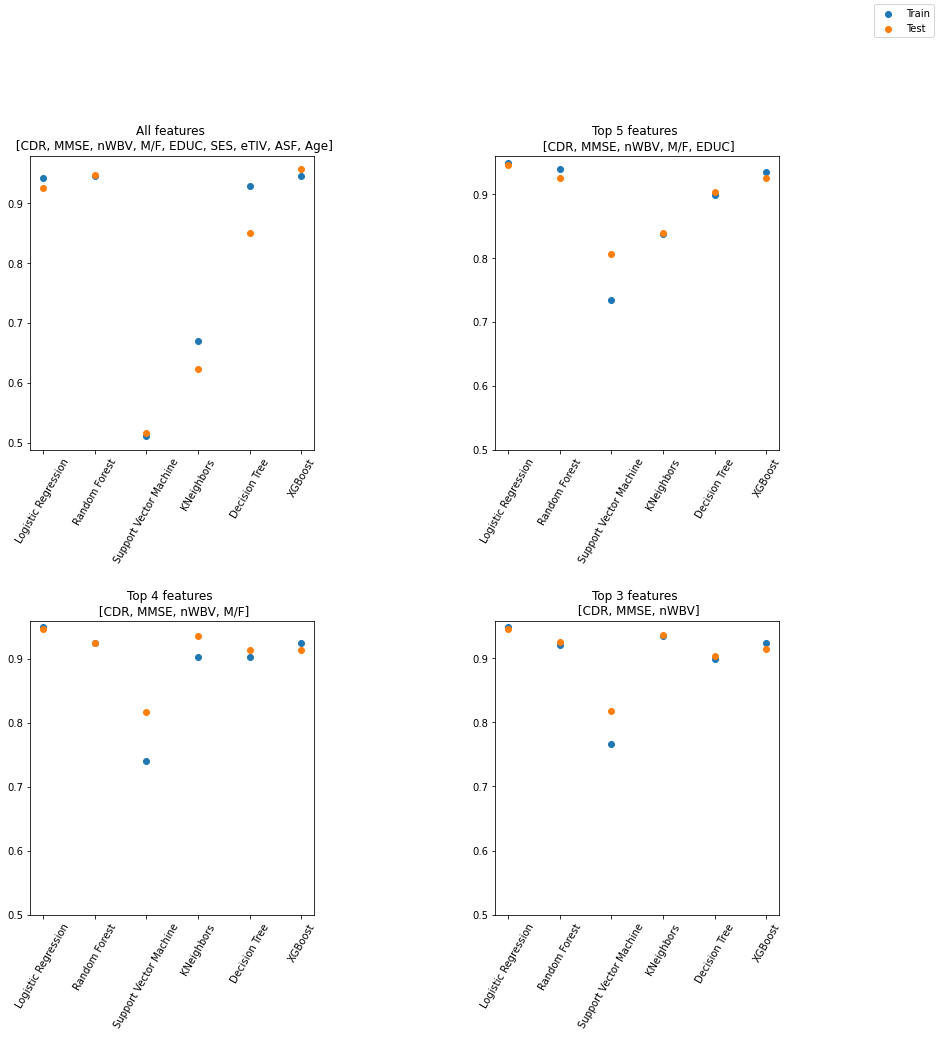

In [31]:
#comparing models with different features based on accuracies

fig, ax = plt.subplots(2, 2, figsize = (15, 15))
fig.tight_layout(pad=15)

ax[0, 0].scatter(models, trainAccurAll, label = 'Train')
ax[0, 0].scatter(models, testAccurAll, label = 'Test')
ax[0, 0].set_xticklabels(rotation = 60, labels = models)
ax[0, 0].set_title('All features \n [CDR, MMSE, nWBV, M/F, EDUC, SES, eTIV, ASF, Age]')

ax[0, 1].scatter(models, trainAccur5Feat)
ax[0, 1].scatter(models, testAccur5Feat)
ax[0, 1].set_xticklabels(rotation = 60, labels = models)
ax[0, 1].set_title('Top 5 features \n [CDR, MMSE, nWBV, M/F, EDUC]')
ax[0, 1].set_ylim(bottom=0.5)

ax[1, 0].scatter(models, trainAccur4Feat)
ax[1, 0].scatter(models, testAccur4Feat)
ax[1, 0].set_xticklabels(rotation = 60, labels = models)
ax[1, 0].set_title('Top 4 features \n [CDR, MMSE, nWBV, M/F]')
ax[1, 0].set_ylim(bottom=0.5)

ax[1, 1].scatter(models, trainAccur3Feat)
ax[1, 1].scatter(models, testAccur3Feat)
ax[1, 1].set_xticklabels(rotation = 60, labels = models)
ax[1, 1].set_title('Top 3 features \n [CDR, MMSE, nWBV]')
ax[1, 1].set_ylim(bottom=0.5)

fig.legend()

In [32]:
#Test accuracy comparision

compareModels = pd.DataFrame()
compareModels['All features test'] = testAccurAll
compareModels['5 features test'] = testAccur5Feat
compareModels['4 features test'] = testAccur4Feat
compareModels['3 features test'] = testAccur3Feat
compareModels.index = models
compareModels.style.background_gradient(cmap='PRGn')

,All features test,5 features test,4 features test,3 features test
Logistic Regression,0.924731,0.946237,0.946237,0.946237
Random Forest,0.946237,0.924731,0.924731,0.924731
Support Vector Machine,0.516129,0.806452,0.817204,0.817204
KNeighbors,0.623656,0.838710,0.935484,0.935484
Decision Tree,0.849462,0.903226,0.913978,0.903226
XGBoost,0.956989,0.924731,0.913978,0.913978


In [33]:
#Train accuracy comparision

compareModelsTrain = pd.DataFrame()
compareModelsTrain['All features train'] = trainAccurAll
compareModelsTrain['5 features train'] = trainAccur5Feat
compareModelsTrain['4 features train'] = trainAccur4Feat
compareModelsTrain['3 features train'] = trainAccur3Feat
compareModelsTrain.index = models
compareModelsTrain.style.background_gradient(cmap='PRGn')

,All features train,5 features train,4 features train,3 features train
Logistic Regression,0.942143,0.949351,0.949351,0.949351
Random Forest,0.945844,0.938571,0.924026,0.920519
Support Vector Machine,0.510779,0.733571,0.740779,0.765909
KNeighbors,0.669351,0.837857,0.902857,0.935000
Decision Tree,0.928052,0.899026,0.902468,0.898896
XGBoost,0.945844,0.934870,0.924091,0.924091


<h2> Model evaluation </h2>

In [34]:
#helper function to plot confusion matrix

def plot_confusion_matrix(cm):
    plt.figure(1)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.winter)
    classNames = ['Nondemented','Demented']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [35]:
#helper function

def printReport(report):
    values = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    for i in range(4):
        print('\t', values[i], ' = ', round(report[i], 4))
    print('\n')

In [36]:
#helper function for plotting rocCurve

def plotRoc_curves(fpr, tpr, thresholds):
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='seagreen', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [37]:
#model evaluation

def getMetrics(X_train, X_test, y_train, y_test):
    #model building
    LR = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=555)
    RF = RandomForestClassifier(n_estimators = 100, random_state=555)
    SVM = SVC(random_state=0, probability=True)
    KNC = KNeighborsClassifier()
    DTC = DecisionTreeClassifier()
    clf_XGB = XGBClassifier(n_estimators = 100, seed=555, use_label_encoder=False, eval_metric='logloss')

    confusionMatrices = []
    classificationReports = []
    predictions = []
    
    for clf, label in zip([LR, RF, SVM, KNC, DTC, clf_XGB],
                          models):
        #training the model
        md = clf.fit(X_train, y_train)
        #predicted values
        prediction = md.predict(X_test)
        
        predictions.append(prediction)
        
        #confusion matrix
        cm = metrics.confusion_matrix(y_test, prediction)
        confusionMatrices.append(cm)
        
        TN = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TP = cm[1][1]
        tot = TN + FP + FN + TP
        
        #calculating model metrics
        accuracy =  (TP + TN) / tot
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1Score = 2*(recall * precision) / (recall + precision)
        classificationReports.append([accuracy, precision, recall, f1Score])
        
    return confusionMatrices, classificationReports, predictions

In [38]:
#Selecting model with top 4 features and spliting data into train and test

X = df[['CDR','MMSE', 'nWBV', 'M/F']]
y = df['GroupNum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=50)
confusionMatrices, classificationReports, predictions = getMetrics(X_train, X_test, y_train, y_test)

	=======Logistic Regression=======


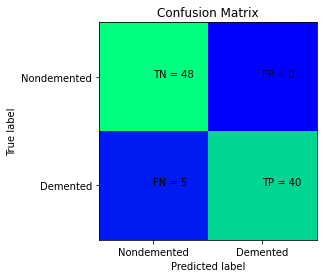

	 Accuracy  =  0.9462
	 Precision  =  1.0
	 Recall  =  0.8889
	 F1-score  =  0.9412




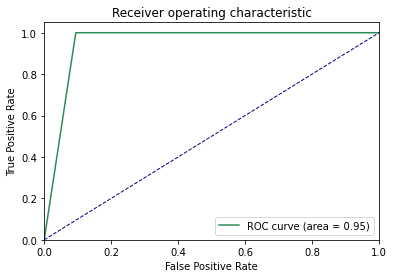

	=======Random Forest Classifier=======


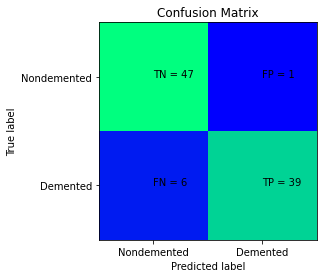

	 Accuracy  =  0.9247
	 Precision  =  0.975
	 Recall  =  0.8667
	 F1-score  =  0.9176




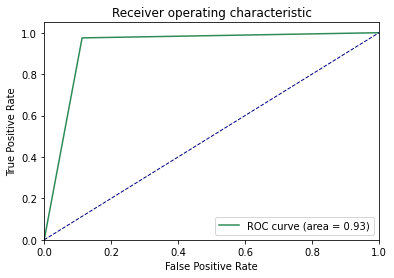

		=======SVM=======


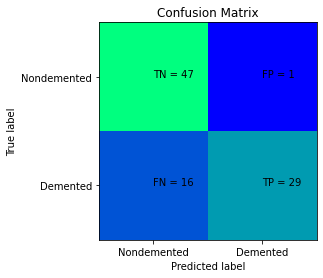

	 Accuracy  =  0.8172
	 Precision  =  0.9667
	 Recall  =  0.6444
	 F1-score  =  0.7733




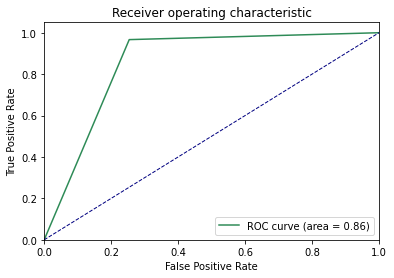

	=======K-Neighbors Classifier=======


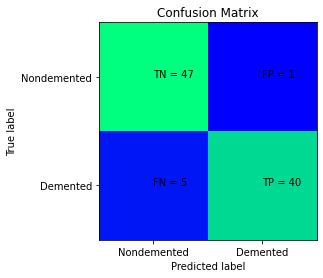

	 Accuracy  =  0.9355
	 Precision  =  0.9756
	 Recall  =  0.8889
	 F1-score  =  0.9302




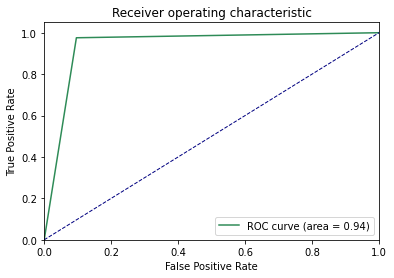

		=======Decision Tree=======


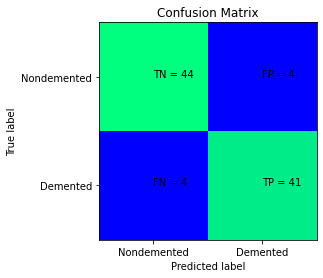

	 Accuracy  =  0.914
	 Precision  =  0.9111
	 Recall  =  0.9111
	 F1-score  =  0.9111




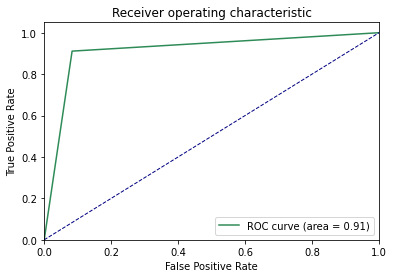

		=======XG Boost=======


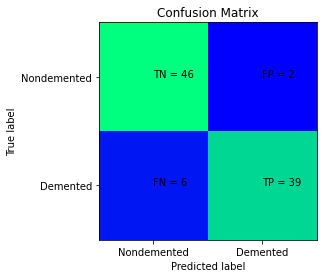

	 Accuracy  =  0.914
	 Precision  =  0.9512
	 Recall  =  0.8667
	 F1-score  =  0.907




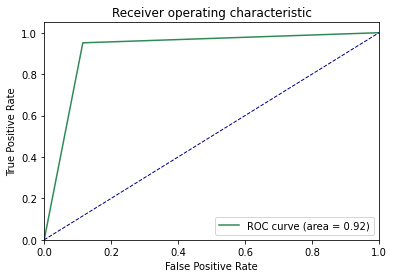

In [39]:
#metrics for individual models

print('\t=======\033[1mLogistic Regression\033[0m=======')
plot_confusion_matrix(confusionMatrices[0])
printReport(classificationReports[0])
fpr, tpr, thresholds = roc_curve(predictions[0], y_test)
plotRoc_curves(fpr, tpr, thresholds)


print('\t=======\033[1mRandom Forest Classifier\033[0m=======')
plot_confusion_matrix(confusionMatrices[1])
printReport(classificationReports[1])
fpr, tpr, thresholds = roc_curve(predictions[1], y_test)
plotRoc_curves(fpr, tpr, thresholds)

print('\t\t=======\033[1mSVM\033[0m=======')
plot_confusion_matrix(confusionMatrices[2])
printReport(classificationReports[2])
fpr, tpr, thresholds = roc_curve(predictions[2], y_test)
plotRoc_curves(fpr, tpr, thresholds)

print('\t=======\033[1mK-Neighbors Classifier\033[0m=======')
plot_confusion_matrix(confusionMatrices[3])
printReport(classificationReports[3])
fpr, tpr, thresholds = roc_curve(predictions[3], y_test)
plotRoc_curves(fpr, tpr, thresholds)

print('\t\t=======\033[1mDecision Tree\033[0m=======')
plot_confusion_matrix(confusionMatrices[4])
printReport(classificationReports[4])
fpr, tpr, thresholds = roc_curve(predictions[4], y_test)
plotRoc_curves(fpr, tpr, thresholds)

print('\t\t=======\033[1mXG Boost\033[0m=======')
plot_confusion_matrix(confusionMatrices[5])
printReport(classificationReports[5])
fpr, tpr, thresholds = roc_curve(predictions[5], y_test)
plotRoc_curves(fpr, tpr, thresholds)

<h2> Prediction </h2>
<h5> using the best model based on above analysis </h5>

In [40]:
LR = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=555)
md = LR.fit(X_train, y_train)
prediction = pd.DataFrame(md.predict(X_test))
print("Test set accuracy: {:.2f}".format(LR.score(X_test, y_test)))

Test set accuracy: 0.95


In [41]:
prediction['Actual'] = pd.DataFrame(y_test).reset_index().drop('index', axis=1)['GroupNum']
prediction.rename(columns={0 : 'Predicted'}, inplace=True)
prediction
#0 = non-demented
#1 = demented

,Predicted,Actual
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1
...,...,...
88,1,1
89,1,1
90,1,1
91,1,1


In [42]:
#rows with wrong predictions (total = 5)

prediction[prediction['Predicted']!=prediction['Actual']]

,Predicted,Actual
23,0,1
43,0,1
66,0,1
75,0,1
81,0,1


In [43]:
print('Intercept= ', LR.intercept_)
print('Coefficients = ', *LR.coef_)

Intercept=  [11.40820533]
Coefficients =  [ 5.52675643 -0.43689842 -0.30847882 -0.23484866]


<h3> Model equation </h3><br>
Y = 11.408 + 5.5268(x1) - 0.437(x2) - 0.309(x3) - 0.235(x4)

where, <br>
Y &nbsp; = Group number<br>
x1 = CDR<br>
x2 = MMSE<br>
x3 = nWBV<br>
x4 = M/F